In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from k12libs.utils.nb_dataset import k12ai_compute_mean_std

# <div align="center"> Compute Mean and Std </div>

## 全量

In [3]:
# datadir = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'mnist')
# jfiles = ['train.json', 'val.json', 'test.json']
# mean, std = k12ai_compute_mean_std(datadir=datadir, jfiles=jfiles)

In [4]:
# mean, std
# [0.1349, 0.1349, 0.1349], 0.1349, 0.1349, 0.1349]

| mean | std |
| :---: | :---: |
|<img width=200/> | <img width=200/>
|[0.1349, 0.1349, 0.1349] | [0.2976, 0.2976, 0.2976] |

## 精简

In [5]:
train_json = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'mnist', 'train.json')
valid_json = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'mnist', 'val.json')
items = []
with open(train_json) as f:
    items_1 = json.load(f)
    items.extend(items_1)
    
with open(valid_json) as f:
    items_2 = json.load(f)
    items.extend(items_2)
    
len(items_1), len(items_2), len(items)

(48000, 12000, 60000)

### 读取

In [6]:
# df = pd.read_json("train.json",encoding="utf-8", orient='records')
df = pd.json_normalize(items)
df[:5]

,image_path,label
0,imgs/train/12787.jpg,7
1,imgs/train/01713.jpg,8
2,imgs/train/54872.jpg,6
3,imgs/train/24758.jpg,8
4,imgs/train/50993.jpg,3


### 查看是否均匀分布

In [7]:
grouped_by_label = df.groupby('label')
grouped_by_label.count()
# grouped_by_label.p

,image_path
label,
0,5923
1,6742
2,5958
3,6131
4,5842
5,5421
6,5918
7,6265
8,5851


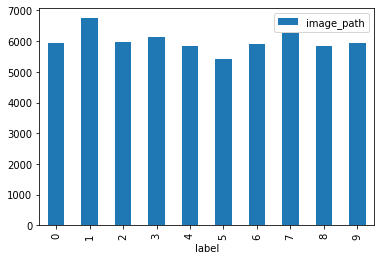

In [8]:
grouped_by_label.count().plot(kind='bar');

### 随机精简

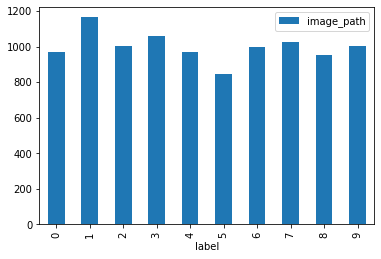

In [9]:
# 不合理: 不平衡的样本
reduced_grouped_by_label = df.sample(n=10000, random_state=10, ).groupby('label')
reduced_grouped_by_label.count().plot(kind='bar');

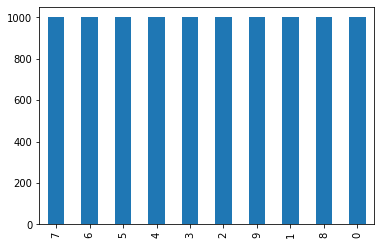

In [10]:
# 合理: 先分组, 然后组中随机样本
reduced_df = df.groupby('label').apply(pd.DataFrame.sample, n=1000, random_state=10, replace=False)
reduced_df['label'].value_counts().plot(kind='bar');

### 对样本随机打散

In [11]:
df[df['image_path'] == "imgs/train/21265.jpg"]

,image_path,label
9127,imgs/train/21265.jpg,3


In [12]:
reduced_shuffle_df = reduced_df.sample(frac=1)
reduced_shuffle_df[:5]

image_path  label
label                                   
3     5623   imgs/train/32238.jpg      3
6     30817  imgs/train/35878.jpg      6
2     37564  imgs/train/51274.jpg      2
7     10724  imgs/train/16000.jpg      7
      48916  imgs/train/26662.jpg      7

### 分割数据集6:2:2

In [13]:
train_valid_df, test_df = train_test_split(reduced_shuffle_df, test_size=0.2)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2)
len(train_df), len(valid_df), len(test_df), len(reduced_shuffle_df)

(6400, 1600, 2000, 10000)

## 保存精简数据集rmnist

In [18]:
def generate_rmnist(df, phase):
    src_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'mnist')
    dst_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', 'rmnist')
    
    img_path = os.path.join(dst_root, 'imgs', phase)
    shutil.rmtree(img_path, ignore_errors=True)
    os.makedirs(img_path)
    
    results = []
    items = df.to_dict(orient='records')
    print(f'{phase} count: {len(items)}')
    for item in items:
        filename = os.path.basename(item['image_path'])
        src_path = os.path.join(src_root, item['image_path'])
        dst_path = os.path.join(img_path, filename)
        if not os.path.exists(src_path):
            print('not found:', src_path)
        if os.path.exists(dst_path):
            print('replce found:', dst_path)
        results.append({
            'image_path': f'imgs/{phase}/{filename}',
            'label': item['label']
        })
        shutil.copy2(src_path, dst_path)
        
    with open(os.path.join(dst_root, f'{phase}.json'), 'w') as f:
        json.dump(results, f)
        
generate_rmnist(test_df, 'test')
generate_rmnist(train_df, 'train')
generate_rmnist(valid_df, 'val')

test count: 2000
train count: 6400
val count: 1600
